In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepshare-playground/sample_submission.csv
/kaggle/input/deepshare-playground/item_info.csv
/kaggle/input/deepshare-playground/user_info.csv
/kaggle/input/deepshare-playground/test_behaviour.csv
/kaggle/input/deepshare-playground/train_behaviour.csv


In [2]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import multiprocessing

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss

# Course-2 主要内容
## 1.数据处理
* 数据读取
* 数据预处理

## 2.模型调用
* scikit-learn 经典模型使用
* lightgbm/xgboost/catboost 模型使用

## 3.模型验证
* hold out验证
* 交叉验证

# 1.数据处理

In [51]:
train_df = pd.read_csv('/kaggle/input/deepshare-playground/train_behaviour.csv')
test_df = pd.read_csv('/kaggle/input/deepshare-playground/test_behaviour.csv')
user_df = pd.read_csv('/kaggle/input/deepshare-playground/user_info.csv')
item_df = pd.read_csv('/kaggle/input/deepshare-playground/item_info.csv')

In [52]:
train_df.shape,test_df.shape

((3363693, 5), (198285, 4))

In [53]:
item_df['item_count'] = item_df['item_id'].map(item_df['item_id'].value_counts())
item_df[item_df['item_count']>1]

,item_id,item_fea1,item_fea2,item_fea3,item_fea4,item_fea5,item_fea6,item_fea7,item_fea8,item_fea9,item_desc,item_count
4506,77235651,1684,1929,29,0,0,7,21,12,0,3963 2567 4366 1978 4971 4929 1870 932 4459 48...,2
4770,37092322,1788,2048,32,0,0,12,20,7,1,1137 1177 4971 854 1868 4835 856 2830 2356,2
4861,13492918,1827,2092,6,0,0,0,7,6,0,2873 4577 2567 4132 3216 1552 4366 1978 4971 7...,2
8860,77235651,3714,4118,29,22,22,7,177,24,10,3963 2567 4987 1978 4971 854 1868 1795 4836 19...,2
9637,13492918,4097,4524,59,0,0,38,27,4,4,2990 3719 2567 4787 1705,2
10987,17832925,4739,5187,1,0,0,1,81,1,1,4133 3148 3000 1146 4971 2714 1717 856 3067 32...,2
13761,17832925,5791,6287,33,0,0,14,155,34,8,3943 2634 2567 4133 4345 4314 4971 774 1457 14...,2
17313,52037980,7416,7971,10,12,12,26,223,18,19,558 872 2646 2567 4867 4269 1691 4971 4984 171...,2
19178,23704936,8291,8849,38,2,2,6,96,38,4,1771 4643 3801 2567 4132 1552 2653,2
21101,97665933,9071,9625,6,13,13,30,125,39,9,2661 2567 774 4133 2046 2700 1511 4145 4977 49...,2


In [54]:
# 发现item_df中有脏数据，需要对其进行去重
item_df = item_df.drop_duplicates(subset=['item_id'], keep='last', inplace=False)
user_df = user_df.drop_duplicates(subset=['user_id'], keep='last', inplace=False)

In [55]:
df = pd.concat([train_df,test_df],axis=0).reset_index(drop=True)
df = df.merge(user_df,on='user_id',how='left').reset_index(drop=True)
df = df.merge(item_df,on='item_id',how='left').reset_index(drop=True)

In [56]:
df.info(verbose=True,null_counts=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561978 entries, 0 to 3561977
Data columns (total 20 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     3561978 non-null  object 
 1   item_id     3561978 non-null  int64  
 2   label       3363693 non-null  float64
 3   day         3561978 non-null  int64  
 4   ID          3561978 non-null  int64  
 5   user_fea1   3561978 non-null  int64  
 6   user_fea2   3561978 non-null  int64  
 7   user_fea3   3561978 non-null  int64  
 8   user_fea4   3560311 non-null  float64
 9   item_fea1   3561978 non-null  int64  
 10  item_fea2   3561978 non-null  int64  
 11  item_fea3   3561978 non-null  int64  
 12  item_fea4   3561978 non-null  int64  
 13  item_fea5   3561978 non-null  int64  
 14  item_fea6   3561978 non-null  int64  
 15  item_fea7   3561978 non-null  int64  
 16  item_fea8   3561978 non-null  int64  
 17  item_fea9   3561978 non-null  int64  
 18  item_desc   3561978 no

In [57]:
num_cols  =  ['user_fea4']
cate_cols = ['user_id','item_id']+[f'user_fea{i}' for i in range(1,4)] + [f'item_fea{i}' for i in range(1,10)]

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


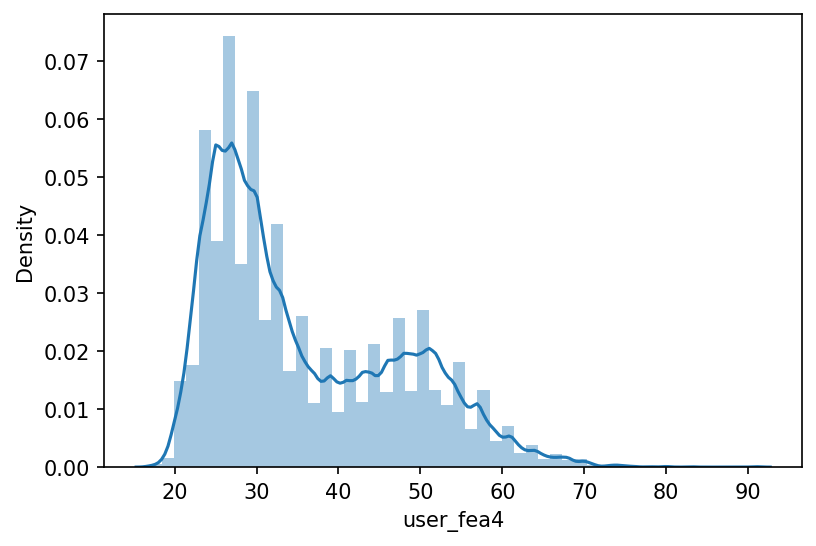

In [58]:
# 连续特征
for col in tqdm(num_cols):
    plt.figure(dpi=150)
    sns.distplot(df[col])

In [59]:
# 原生数据编码
for col in tqdm(num_cols):
    # min-max
#     df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    # z-score
    df[col] = df[col].fillna(0)
    df[col] = (df[col] - df[col].mean()) / df[col].std()

  0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
df.info(verbose=True,null_counts=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561978 entries, 0 to 3561977
Data columns (total 20 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     3561978 non-null  object 
 1   item_id     3561978 non-null  int64  
 2   label       3363693 non-null  float64
 3   day         3561978 non-null  int64  
 4   ID          3561978 non-null  int64  
 5   user_fea1   3561978 non-null  int64  
 6   user_fea2   3561978 non-null  int64  
 7   user_fea3   3561978 non-null  int64  
 8   user_fea4   3561978 non-null  float64
 9   item_fea1   3561978 non-null  int64  
 10  item_fea2   3561978 non-null  int64  
 11  item_fea3   3561978 non-null  int64  
 12  item_fea4   3561978 non-null  int64  
 13  item_fea5   3561978 non-null  int64  
 14  item_fea6   3561978 non-null  int64  
 15  item_fea7   3561978 non-null  int64  
 16  item_fea8   3561978 non-null  int64  
 17  item_fea9   3561978 non-null  int64  
 18  item_desc   3561978 no

In [61]:
# sklearn 数据编码
# scaler = StandardScaler()
# scaler = MinMaxScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


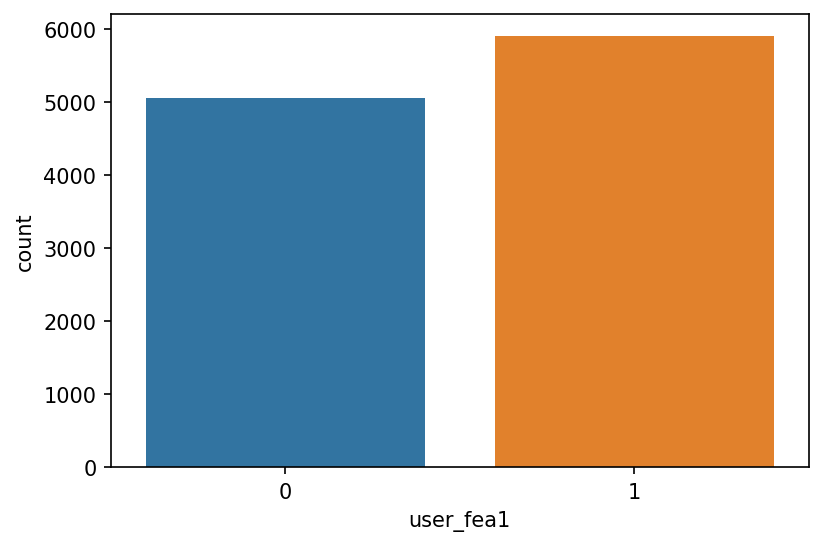

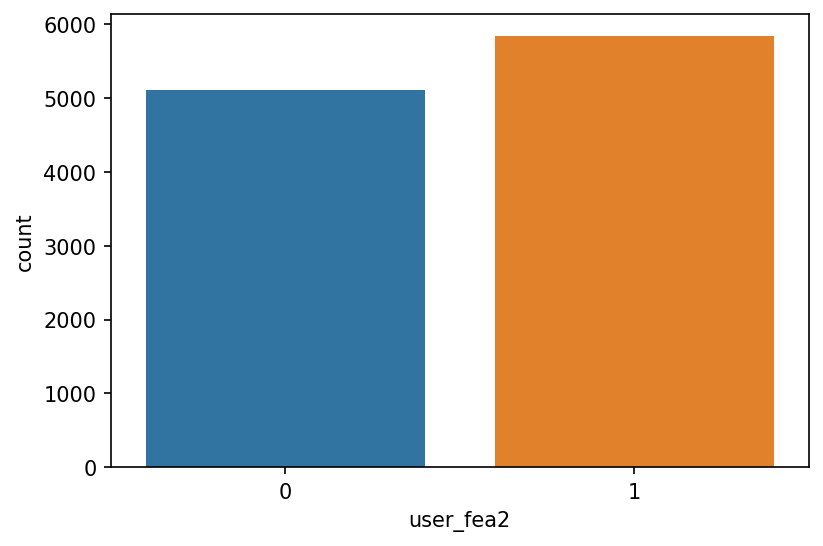

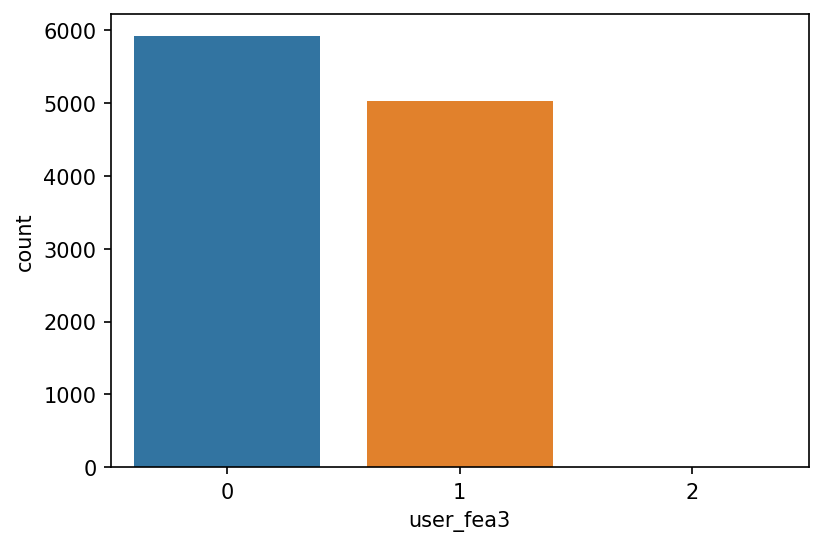

In [42]:
# 离散特征
for col in tqdm(['user_fea1','user_fea2','user_fea3']):
    plt.figure(dpi=150)
    sns.countplot(user_df[col])

In [62]:
# 原生离散特征编码
for col in tqdm(cate_cols):
    map_dict = dict(zip(df[col].unique(), range(df[col].nunique())))
    df[col] = df[col].map(map_dict)
#     df[f'{col}_count'] = df[col].map(df[col].value_counts())

  0%|          | 0/14 [00:00<?, ?it/s]

In [63]:
# # sklearn 离散特征编码
# for col in tqdm(cate_cols):
#     scale = LabelEncoder()
#     scale.fit(df[col])
#     df[col] = scale.transform(df[col])

In [64]:
train_df = df[df['label'].notna()].reset_index(drop=True)
test_df = df[df['label'].isna()].reset_index(drop=True)

In [66]:
drop_feature = ['ID','label', 'day', 'item_desc']
feature = [x for x in train_df.columns if x not in drop_feature]
print(len(feature),feature)

16 ['user_id', 'item_id', 'user_fea1', 'user_fea2', 'user_fea3', 'user_fea4', 'item_fea1', 'item_fea2', 'item_fea3', 'item_fea4', 'item_fea5', 'item_fea6', 'item_fea7', 'item_fea8', 'item_fea9', 'item_count']


# 2.模型调用

In [67]:
### sklearn一般的范式
'''
# 拟合模型
model.fit(X_train, y_train)

# 模型预测 类别
model.predict(X_test)

# 输出概率(分类任务)
model.predict_proba(X_test)

# 获得这个模型的参数
model.get_params()
'''

'\n# 拟合模型\nmodel.fit(X_train, y_train)\n\n# 模型预测 类别\nmodel.predict(X_test)\n\n# 输出概率(分类任务)\nmodel.predict_proba(X_test)\n\n# 获得这个模型的参数\nmodel.get_params()\n'

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[feature], train_df['label'], random_state=666)

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


model = RandomForestClassifier()

model.fit(X_train, y_train)

y_valid_pre = model.predict_proba(X_valid)[:,1]

print(f'{str(model)} AUC :{roc_auc_score(y_valid, y_valid_pre)}')

print(f'{str(model)} LogLoss :{log_loss(y_valid, y_valid_pre)}')

y_pre = model.predict_proba(test_df[feature])[:,1]

RandomForestClassifier() AUC :0.8085148853035365
RandomForestClassifier() LogLoss :0.4037055904442491


In [70]:
sklearn_sub_df = pd.DataFrame()
sklearn_sub_df['ID'] = test_df['ID']
sklearn_sub_df['predict'] = y_pre
sklearn_sub_df.to_csv('/kaggle/working/sklearn_baseline.csv',index=False)

# 3.模型验证

In [71]:
params = {'num_leaves': 63, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.1,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 1,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 1,
          "bagging_seed": 11,
#           "lambda_l1": 0.1,             #l1正则
          # 'lambda_l2': 0.001,     #l2正则
          "verbosity": -1,
          "nthread": multiprocessing.cpu_count(),                #线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 2077, #随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

n_fold = 5
oof_pre = np.zeros(len(train_df))
y_pre = np.zeros(len(test_df))

kf = KFold(n_splits=n_fold)
for fold_, (trn_idx, val_idx) in enumerate(kf.split(train_df)):
    trn_data = lgb.Dataset(train_df[feature].iloc[trn_idx], label=train_df['label'].iloc[trn_idx])
    val_data = lgb.Dataset(train_df[feature].iloc[val_idx], label=train_df['label'].iloc[val_idx])

    clf = lgb.train(params,
                    trn_data,
                    2000,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=50,
                    early_stopping_rounds=50)
    
    oof_pre[val_idx] = clf.predict(train_df[feature].iloc[val_idx], num_iteration=clf.best_iteration)

    y_pre += clf.predict(test_df[feature], num_iteration=clf.best_iteration) / n_fold

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.959915	training's binary_logloss: 0.238232	valid_1's auc: 0.790518	valid_1's binary_logloss: 0.423576
Early stopping, best iteration is:
[20]	training's auc: 0.907763	training's binary_logloss: 0.314691	valid_1's auc: 0.782801	valid_1's binary_logloss: 0.415312
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.959981	training's binary_logloss: 0.24081	valid_1's auc: 0.825043	valid_1's binary_logloss: 0.378635
Early stopping, best iteration is:
[39]	training's auc: 0.945277	training's binary_logloss: 0.262422	valid_1's auc: 0.824738	valid_1's binary_logloss: 0.376817
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.95653	training's binary_logloss: 0.247438	valid_1's auc: 0.832445	valid_1's binary_logloss: 0.353792
Early stopping, best iteration is:
[30]	training's auc: 0.926052	training's binary_logloss: 0.291725	valid_1's auc: 0.834532

In [75]:
local_auc = roc_auc_score(train_df['label'], oof_pre)
print(f'Local AUC :{local_auc}')

Local AUC :0.8132631828325829


In [73]:
res_df = pd.DataFrame()
res_df['ID'] = test_df['ID']
res_df['predict'] = y_pre
res_df.to_csv('/kaggle/working/lgb-baseline.csv',index=False)